In [1]:
# import libraries
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

In [2]:
# create dataset class for AffectNet
class AffectNetImageDataset(Dataset):
    """AffectNet Facial Expressions Dataset"""

    def __init__(self, annotations_file, img_dir, transform=None):
        """
        Args:
            annotations_file: Path to the csv file with annotations.
            img_dir: Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# create dataset class for fer_ckplus_kdef
class fer_ckplus_kdefImageDataset(Dataset):
    """fer_ckplus_kdef Facial Expressions Dataset"""

    def __init__(self, annotations_file, img_dir, transform=None):
        """
        Args:
            annotations_file: Path to the csv file with annotations.
            img_dir: Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = torch.stack([image, image, image]).squeeze() # convert 1 channel to 3 channel to match with model
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
    
# resize all images to 224 x 224
transform = transforms.Compose([transforms.Resize(224),
                                transforms.Grayscale(3)])

train_data = AffectNetImageDataset(annotations_file='./data/train_set/annotations/labels.csv',
                                   img_dir='./data/train_set/images/',
                                   transform=transform)
val_data = AffectNetImageDataset(annotations_file='./data/val_set/annotations/labels.csv',
                                   img_dir='./data/val_set/images/',
                                   transform=transform)
test_data = fer_ckplus_kdefImageDataset(annotations_file='./data/test_set/annotations/labels.csv',
                                   img_dir='./data/test_set/images/',
                                   transform=transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))

Num training images:  52500
Num validation images:  980
Num testing images:  1820


In [3]:
# create dataloader
###########################################################
# put this in training function if batch_size is a training fuction parameter
###########################################################
def get_data_loader(data, batch_size=64, num_workers=16):
    data_loader = DataLoader(data, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True)
    return data_loader

# Fixed PyTorch random seed for reproducible result
torch.manual_seed(1000)

# Obtain the PyTorch data loader objects to load batches of the datasets
train_loader = get_data_loader(train_data, batch_size=64, num_workers=16)
val_loader = get_data_loader(val_data, batch_size=64, num_workers=16)
test_loader = get_data_loader(test_data, batch_size=64, num_workers=16)

Visualize TRAIN images


/tmp/ipykernel_6266/2865572008.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


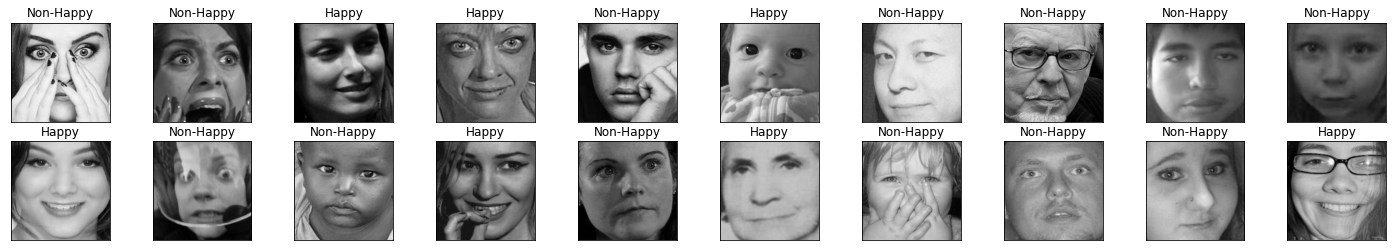

In [8]:
# Visualize some data images
labels_encoder_binary = {0: "Non-Happy", 1: "Happy"}

####################################
# display TRAIN images
print("Visualize TRAIN images")
# obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
labels = labels.numpy() # convert labels to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels_encoder_binary[labels[idx]])

Visualize VALID images


/tmp/ipykernel_6266/2203701119.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


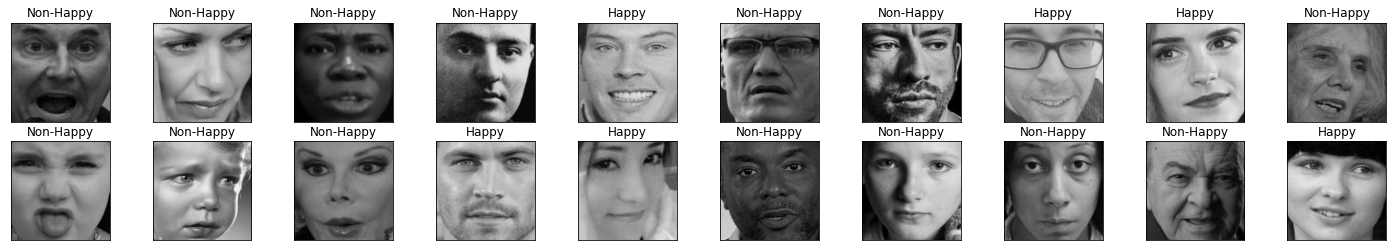

In [9]:
####################################
# display VALID images
print("Visualize VALID images")
# obtain one batch of images
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
labels = labels.numpy() # convert labels to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels_encoder_binary[labels[idx]])

Visualize TEST images


/tmp/ipykernel_6266/1308597007.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


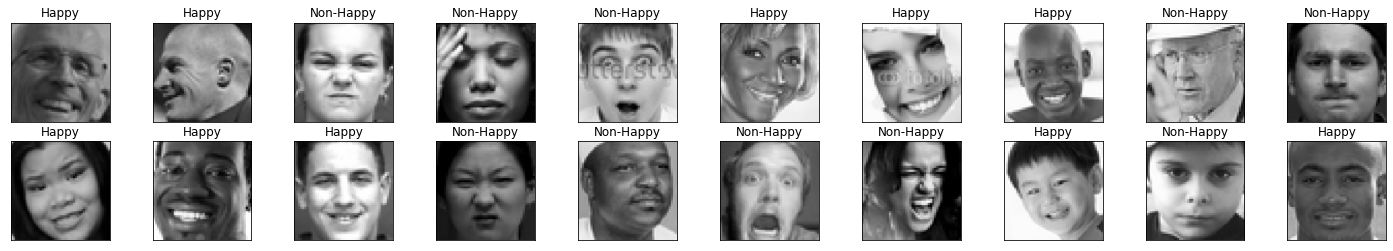

In [11]:
####################################
# display TEST images
print("Visualize TEST images")
# obtain one batch of images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
labels = labels.numpy() # convert labels to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels_encoder_binary[labels[idx]])

In [12]:
def get_feature_loader(pretrained_model, data, batch_size=64, num_workers=16):
    '''
    Extract convolutional features from a dataset with a pretrained model method.
    Then, generate a feature loader as (features, labels).
    '''
    # Obtain the PyTorch data loader object to load batches of the dataset
    data_loader = get_data_loader(data, batch_size=1, num_workers=num_workers)
    
    # Create empty list to store features extracted
    feature_data = []
    for imgs, labels in tqdm(data_loader):
        
        # img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
        features = pretrained_model.features(imgs/255) #SLOW
        feature_data.append([features.detach().squeeze().numpy(), labels.squeeze().numpy()])
        
    # Create a feature loader from created feature data
    feature_loader = get_data_loader(feature_data, batch_size=batch_size, num_workers=num_workers)

    return feature_loader

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)
        
        pred = (output > 0.0).squeeze().long() == labels
        correct += int(pred.sum())
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "./weights/model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

# Updated train function to consider precomputed features
def train_updated(model, train_data, val_data, batch_size=64, learning_rate=0.001, num_epochs=1, checkpoint=False, transfer_learning=False, pretrained_model=None):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    print('Feature Extraction Started.')
    if transfer_learning:
        train_loader = get_feature_loader(pretrained_model, train_data, batch_size=batch_size, num_workers=16)
        val_loader = get_feature_loader(pretrained_model, val_data, batch_size=batch_size, num_workers=16)

    else:
        train_loader = get_data_loader(train_data, batch_size=batch_size, num_workers=16)
        val_loader = get_data_loader(val_data, batch_size=batch_size, num_workers=16)
    print('Feature Extraction Finished.')
    
    # Define the Loss function and optimizer
    # The loss function will be BCEwithCrossEntropy Loss for binary classification. It also applies softmax activation internally.
    # Optimizer will be Adam to incorporate common hyperparameters for easy turning.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set up some empty lists to store the training/test loss/erruracy
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0 # the number of iterations
    
    # Train the network
    print('Training Started.')
    start_time = time.time()
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        for imgs, labels in iter(train_loader):
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
        
            out = model(imgs)             # forward pass
            loss = criterion(out, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            
            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1
         
        # track epoch accuracy
        print('Epoch: ',epoch,' Train Acc: ',train_acc[-1],' Valid Acc: ',val_acc[-1])
        
        # Save the current model (checkpoint) to a file
        if checkpoint:
            model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)
    
    print('Training Finished.')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.ylim(0, 1) # set the same axis range for clear comparison
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [13]:
class HappyFaceClassifier_alex(nn.Module):
    def __init__(self):
        super(HappyFaceClassifier_alex, self).__init__()
        self.name = "HFC_alex"
        self.fc1 = nn.Linear(256*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = x.view(-1, 256*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [14]:
# GPU Training Enabled
use_cuda = True

CUDA is available!  Training on GPU ...
Feature Extraction Started.


100%|█████████████████████████████████████████| 980/980 [00:17<00:00, 56.08it/s]


Feature Extraction Finished.
Training Started.


 10%|████▎                                      | 1/10 [05:18<47:45, 318.34s/it]

Epoch:  0  Train Acc:  0.7917333333333333  Valid Acc:  0.789795918367347


 20%|████████▌                                  | 2/10 [10:38<42:35, 319.39s/it]

Epoch:  1  Train Acc:  0.8403809523809523  Valid Acc:  0.8387755102040816


 30%|████████████▉                              | 3/10 [15:53<37:01, 317.42s/it]

Epoch:  2  Train Acc:  0.8538857142857142  Valid Acc:  0.8459183673469388


 40%|█████████████████▏                         | 4/10 [21:08<31:37, 316.26s/it]

Epoch:  3  Train Acc:  0.8648  Valid Acc:  0.8520408163265306


 50%|█████████████████████▌                     | 5/10 [26:21<26:16, 315.35s/it]

Epoch:  4  Train Acc:  0.8685142857142857  Valid Acc:  0.8622448979591837


 60%|█████████████████████████▊                 | 6/10 [31:35<20:59, 314.81s/it]

Epoch:  5  Train Acc:  0.8707047619047619  Valid Acc:  0.8520408163265306


 70%|██████████████████████████████             | 7/10 [36:53<15:47, 315.73s/it]

Epoch:  6  Train Acc:  0.8877333333333334  Valid Acc:  0.8540816326530613


 80%|██████████████████████████████████▍        | 8/10 [42:08<10:31, 315.62s/it]

Epoch:  7  Train Acc:  0.8768571428571429  Valid Acc:  0.8397959183673469


 90%|██████████████████████████████████████▋    | 9/10 [47:22<05:15, 315.25s/it]

Epoch:  8  Train Acc:  0.8987238095238095  Valid Acc:  0.8408163265306122


100%|██████████████████████████████████████████| 10/10 [52:37<00:00, 315.78s/it]

Epoch:  9  Train Acc:  0.8900380952380952  Valid Acc:  0.8438775510204082
Training Finished.
Total time elapsed: 3157.85 seconds


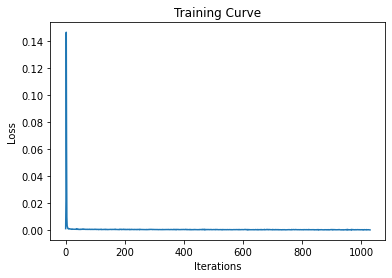

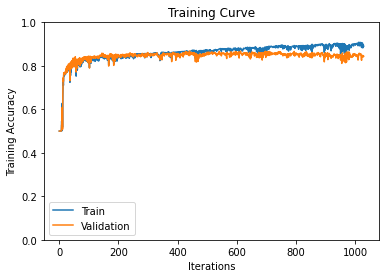

Final Training Accuracy: 0.8900380952380952
Final Validation Accuracy: 0.8438775510204082


In [15]:
alexnet = torchvision.models.alexnet(pretrained=True)

# Transfer learning model with batch_size=512, learning_rate=0.005
model = HappyFaceClassifier_alex()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Training
train_updated(model, train_data, val_data, batch_size=512, learning_rate=0.005, num_epochs=10, checkpoint=True, transfer_learning=True, pretrained_model=alexnet)

In [16]:
# Final transfer learning model with batch_size=512, learning_rate=0.005, epoch=8
alexnet = torchvision.models.alexnet(pretrained=True)
model = HappyFaceClassifier_alex()

if use_cuda and torch.cuda.is_available():
  model.cuda()

# get the best trained model
model_path = get_model_name(model.name, batch_size=512, learning_rate=0.005, epoch=8)
state = torch.load(model_path)
model.load_state_dict(state)

# feature extraction done using alexnet
train_feature_loader = get_feature_loader(alexnet, train_data, batch_size=512, num_workers=16)
val_feature_loader = get_feature_loader(alexnet, val_data, batch_size=512, num_workers=16)
test_feature_loader = get_feature_loader(alexnet, test_data, batch_size=512, num_workers=16)

# compute accuracy
train_acc = get_accuracy(model, train_feature_loader)
val_acc= get_accuracy(model, val_feature_loader)
test_acc = get_accuracy(model, test_feature_loader)

print("Transfer learning model with train acc of {0:.2f}, val acc of {1:.2f} has test acc {2:.2f} ".format(train_acc,val_acc,test_acc))

100%|███████████████████████████████████████| 1820/1820 [00:32<00:00, 56.11it/s]


Transfer learning model with train acc of 0.90, val acc of 0.84 has test acc 0.69 
